# Delegation DID

In [11]:
import stata_setup

stata_setup.config('/Applications/StataNow', 'mp')

In [12]:
%%stata

clear all
set more off
set varabbrev off
version 18

* Paths
global PROCESSED_DATA "processed_data"
global TABLES "tables"
global FIGURES "figures"
global OUTPUT "replace varwidth(25) mlabels(, titles) scalars(N r2_a r2_p N_clust) sfmt(%9.0fc %9.3fc %9.3fc %9.0fc) noobs b(3) t(2) starlevels(* 0.10 ** 0.05 *** 0.01) nogaps nocons"

* Constants
local window = 6


. 
. clear all

. set more off

. set varabbrev off

. version 18

. 
. * Paths
. global PROCESSED_DATA "processed_data"

. global TABLES "tables"

. global FIGURES "figures"

. global OUTPUT "replace varwidth(25) mlabels(, titles) scalars(N r2_a r2_p N_c
> lust) sfmt(%9.0fc %9.3fc %9.3fc %9.0fc) noobs b(3) t(2) starlevels(* 0.10 ** 
> 0.05 *** 0.01) nogaps nocons"

. 
. * Constants
. local window = 6

. 


In [13]:
%%stata
import delimited using "$PROCESSED_DATA/reg_did_delegation.csv", clear

egen ct_fe = group(cohort time)
egen cp_fe = group(cohort space)


eststo clear

* Label variables
label variable non_whale_participation "\${\it Participation}^{Small}_{i,t}\$"
label variable whale_participation "\${\it Participation}^{Whale}_{i,t}\$"
label variable treat "\${\it Treat}_{i}\$"
label variable post "\${\it Post}_{t}\$"

* Small Shareholders Delegation Participation
reghdfe non_whale_participation c.treat##c.post, ///
    absorb(ct_fe cp_fe) vce(cluster space)
estadd local fe_token "Y"
estadd local fe_time "Y"
eststo non_whale_participation

* Whale Delegation Participation
reghdfe whale_participation c.treat##c.post, ///
    absorb(ct_fe cp_fe) vce(cluster space)
estadd local fe_token "Y"
estadd local fe_time "Y"
eststo whale_participation

* Export LaTeX table
esttab                                                      ///
    non_whale_participation whale_participation             ///
    using "$TABLES/reg_did_delegation.tex", replace         ///
    se star(* 0.10 ** 0.05 *** 0.01) nogaps nocon           ///
    b(%9.3f) se(%9.2f)                                      ///
    label nogaps booktabs nonotes noomitted eqlabels(none)  ///
    mtitles("\${\it Participation}^{Small}_{i,t}\$"         ///
    "\${\it Participation}^{Whale}_{i,t}\$")                ///  
    substitute("\_" "_")                                    ///
    stats(fe_token fe_time N r2_a,                          ///
        fmt(0 0 %9.0fc %9.3f)                               ///
         labels("Cohort-DAO FE" "Cohort-Year FE" "Observations" "Adjusted R²"))


. import delimited using "$PROCESSED_DATA/reg_did_delegation.csv", clear
(encoding automatically selected: ISO-8859-1)
(9 vars, 1,780 obs)

. 
. egen ct_fe = group(cohort time)

. egen cp_fe = group(cohort space)

. 
. 
. eststo clear

. 
. * Label variables
. label variable non_whale_participation "\${\it Participation}^{Small}_{i,t}\$
> "

. label variable whale_participation "\${\it Participation}^{Whale}_{i,t}\$"

. label variable treat "\${\it Treat}_{i}\$"

. label variable post "\${\it Post}_{t}\$"

. 
. * Small Shareholders Delegation Participation
. reghdfe non_whale_participation c.treat##c.post, ///
>     absorb(ct_fe cp_fe) vce(cluster space)
(dropped 29 singleton observations)
(MWFE estimator converged in 8 iterations)
note: treat is probably collinear with the fixed effects (all partialled-out va
> lues are close to zero; tol = 1.0e-09)
note: post is probably collinear with the fixed effects (all partialled-out val
> ues are close to zero; tol = 1.0e-09)

HDFE Linear reg

In [14]:
%%stata
forval i = `window'(-1)1 {
    gen treat__`i' = treat * (event_time == -`i')
}
forval i = 0(1)`window' {
    gen treat_`i' = treat * (event_time == `i')
}
drop treat__1
eststo: reghdfe non_whale_participation c.treat_*, ///
    absorb(ct_fe cp_fe) vce(cluster space)


. forval i = `window'(-1)1 {
  2.     gen treat__`i' = treat * (event_time == -`i')
  3. }

. forval i = 0(1)`window' {
  2.     gen treat_`i' = treat * (event_time == `i')
  3. }

. drop treat__1

. eststo: reghdfe non_whale_participation c.treat_*, ///
>     absorb(ct_fe cp_fe) vce(cluster space)
(dropped 29 singleton observations)
(MWFE estimator converged in 8 iterations)

HDFE Linear regression                            Number of obs   =      1,645
Absorbing 2 HDFE groups                           F(  12,     68) =       2.57
Statistics robust to heteroskedasticity           Prob > F        =     0.0072
                                                  R-squared       =     0.7755
                                                  Adj R-squared   =     0.7292
                                                  Within R-sq.    =     0.0017
Number of clusters (space)   =         69         Root MSE        =     0.0427

                                 (Std. err. adjusted for 69 clust


. ****************************************************
. * Extract coefficient vectors
. ****************************************************
. matrix b = e(b)

. matrix V = e(V)

. 
. ****************************************************
. * Create event-time dataset
. ****************************************************
. 
. preserve

. clear

. set obs `=`window'*2 + 1'
Number of observations (_N) was 0, now 13.

. 
. gen event_time = -`window' + _n - 1

. gen beta = .
(13 missing values generated)

. gen se   = .
(13 missing values generated)

. 
. ****************************************************
. * Fill coefficients except base period (-1)
. ****************************************************
. 
. forvalues t = -`window'/`window' {
  2. 
.     if `t' == -1 {
  3.         replace beta = 0 if event_time == `t'
  4.         replace se   = 0 if event_time == `t'
  5.     }
  6.     else {
  7. 
.         if `t' < 0 {
  8.             local varname = "treat__" + string(abs(`t'))


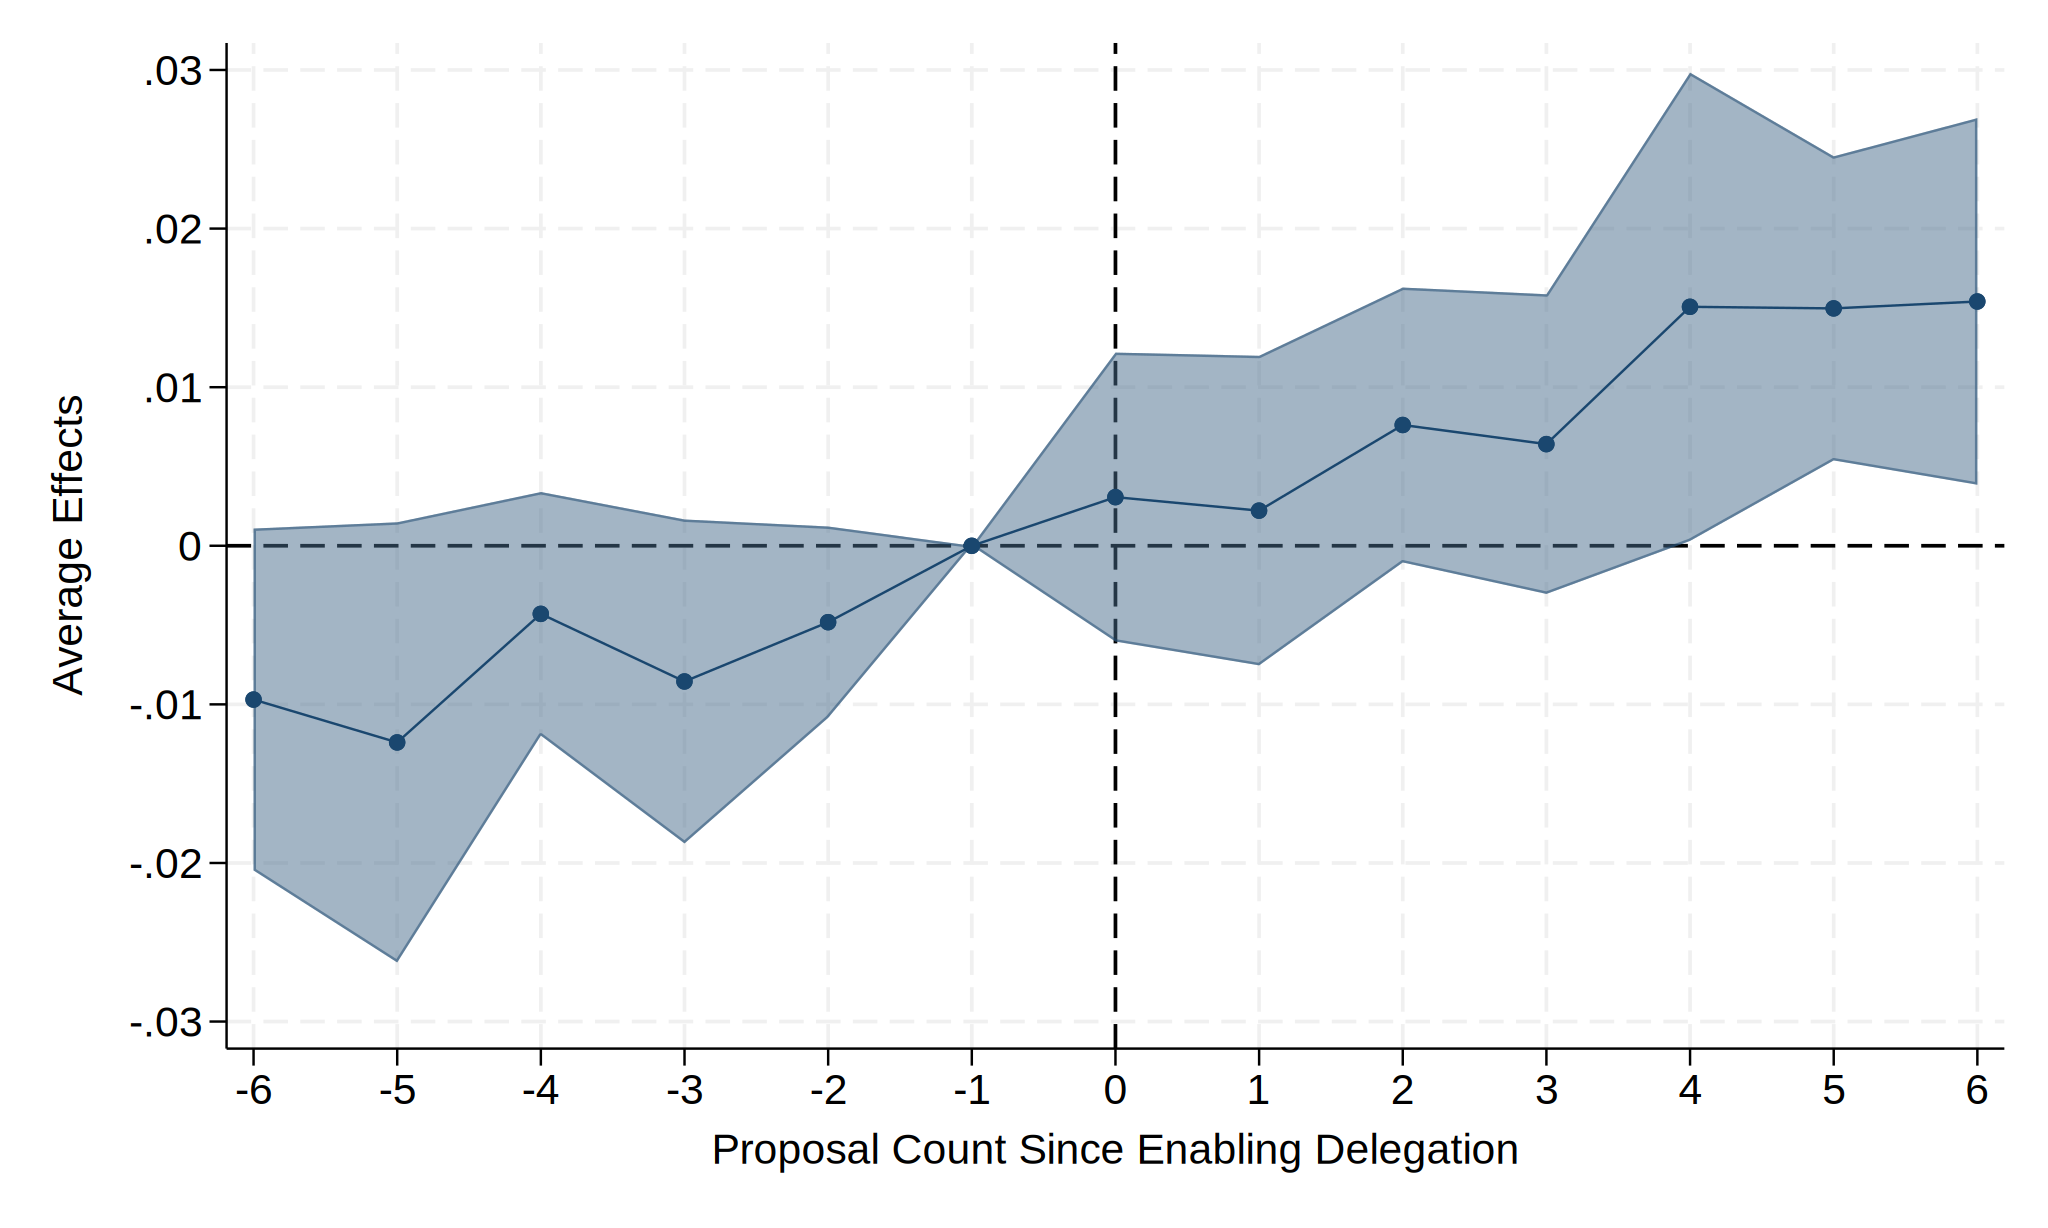

In [15]:
%%stata
****************************************************
* Extract coefficient vectors
****************************************************
matrix b = e(b)
matrix V = e(V)

****************************************************
* Create event-time dataset
****************************************************

preserve
clear
set obs `=`window'*2 + 1'

gen event_time = -`window' + _n - 1
gen beta = .
gen se   = .

****************************************************
* Fill coefficients except base period (-1)
****************************************************

forvalues t = -`window'/`window' {

    if `t' == -1 {
        replace beta = 0 if event_time == `t'
        replace se   = 0 if event_time == `t'
    }
    else {

        if `t' < 0 {
            local varname = "treat__" + string(abs(`t'))
        }
        else {
            local varname = "treat_" + string(`t')
        }

        replace beta = b[1,"`varname'"]                 if event_time == `t'
        replace se   = sqrt(V["`varname'","`varname'"]) if event_time == `t'
    }
}



****************************************************
* 90% CI
****************************************************

gen ub = beta + invttail(e(df_r), 0.1)*se
gen lb = beta - invttail(e(df_r), 0.1)*se

****************************************************
* EVENT STUDY PLOT
****************************************************

twoway ///
    rarea ub lb event_time, ///
        color(navy%50) ///
        lcolor(navy) lwidth(thin)  ///
    || ///
    line beta event_time, ///
        lcolor(navy) lwidth(thin) ///
    || ///
    scatter beta event_time, ///
        mcolor(navy) msymbol(O) msize(small) ///
    ///
    xline(0, lcolor(black) lpattern(dash)) ///
    yline(0, lcolor(black) lpattern(dash)) ///
    ///
    xtitle("Proposal Count Since Enabling Delegation") ///
    ytitle("Average Effects") ///
    ///
    xlabel(-`window'(1)`window', grid gmin gmax) ///
    yscale(range(-0.03 0.03)) ///
    ylabel(-0.03(0.01)0.03) ///
    legend(off) ///
    ///
    plotregion(color(white)) ///
    graphregion(color(white))

graph export "$FIGURES/dynamic_delegation.pdf", replace

restore
